In [17]:
import pandas as pd
import plotly
from plotly import express as px 
import numpy as np
from operator import attrgetter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_df = pd.read_csv(r"online_retail_II.csv")
# Dataset -> https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

In [3]:
raw_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
raw_df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
a = []
for i in raw_df.loc[raw_df['Customer ID'].isnull()].index:
    a.append(i)

In [6]:
raw_df.drop(index=a, inplace = True)

In [7]:
raw_df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [8]:
# changing dtype from float to int
raw_df['Customer ID'] = raw_df['Customer ID'].astype(int)

In [9]:
# Converting the Invoice date to Month
raw_df['InvoiceDate'] = pd.to_datetime(raw_df['InvoiceDate']).dt.to_period('M')

In [10]:
raw_df1 = raw_df[['Customer ID', 'InvoiceDate','Invoice', 'Country']]

In [11]:
raw_df1['Customer ID'].nunique()

5942

In [12]:
# Identifying Customers first ever Month they ordered 
mindate = raw_df1.groupby('Customer ID').agg({'InvoiceDate': ['min']})
mindate.head()

,InvoiceDate
,min
Customer ID,
12346,2009-12
12347,2010-10
12348,2010-09
12349,2009-12
12350,2011-02


In [13]:
# making a dataframe of Customers and their first Month
mindate.columns = mindate.columns.droplevel(-1)
mindate.reset_index(inplace=True)
mindate.rename(columns={'InvoiceDate':'min InvoiceDate'}, inplace = True)
mindate

,Customer ID,min InvoiceDate
0,12346,2009-12
1,12347,2010-10
2,12348,2010-09
3,12349,2009-12
4,12350,2011-02
...,...,...
5937,18283,2010-02
5938,18284,2010-10
5939,18285,2010-02
5940,18286,2009-12


In [14]:
df = raw_df1.merge(mindate, how='left', on = 'Customer ID')

In [20]:
df

,Customer ID,InvoiceDate,Invoice,Country,Month,Month range
0,13085,2009-12,489434,United Kingdom,2009-12,0
1,13085,2009-12,489434,United Kingdom,2009-12,0
2,13085,2009-12,489434,United Kingdom,2009-12,0
3,13085,2009-12,489434,United Kingdom,2009-12,0
4,13085,2009-12,489434,United Kingdom,2009-12,0
...,...,...,...,...,...,...
824359,12680,2011-12,581587,France,2011-08,4
824360,12680,2011-12,581587,France,2011-08,4
824361,12680,2011-12,581587,France,2011-08,4
824362,12680,2011-12,581587,France,2011-08,4


In [18]:
df['Month range'] = (df['InvoiceDate'] - df['min InvoiceDate']).apply(attrgetter('n'))

In [19]:
df.rename(columns={'min InvoiceDate':'Month'}, inplace = True)

In [21]:
main = df[['Customer ID','Month','Month range', 'Country']]

In [22]:
main.drop_duplicates(inplace= True)

/var/folders/l4/c6918mx90x53w5cssvnhgr9c0000gp/T/ipykernel_22231/2507675259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main.drop_duplicates(inplace= True)


In [24]:
cohort =  main.pivot_table(index='Month', columns='Month range', values='Customer ID', aggfunc='count')

In [26]:
cc = cohort.iloc[:,0]

In [27]:
cohort = cohort.divide(cc, axis = 0)

In [28]:
cohort

Month range,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Month,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.375120,0.342584,0.427751,0.392344,0.391388,0.390431,0.357895,0.339713,0.375120,...,0.305263,0.261244,0.302392,0.289952,0.274641,0.262201,0.317703,0.305263,0.408612,0.208612
2010-01,1.0,0.218274,0.302030,0.304569,0.279188,0.291878,0.269036,0.230964,0.289340,0.340102,...,0.152284,0.218274,0.187817,0.175127,0.185279,0.236041,0.187817,0.223350,0.073604,NaN
2010-02,1.0,0.300275,0.225895,0.303030,0.256198,0.209366,0.217631,0.283747,0.275482,0.292011,...,0.203857,0.184573,0.168044,0.146006,0.234160,0.247934,0.170799,0.063361,NaN,NaN
2010-03,1.0,0.217890,0.259174,0.236239,0.229358,0.199541,0.240826,0.298165,0.288991,0.114679,...,0.169725,0.174312,0.158257,0.169725,0.204128,0.213303,0.075688,NaN,NaN,NaN
2010-04,1.0,0.230241,0.199313,0.161512,0.185567,0.230241,0.271478,0.261168,0.113402,0.116838,...,0.147766,0.140893,0.140893,0.171821,0.209622,0.065292,NaN,NaN,NaN,NaN
2010-05,1.0,0.192913,0.177165,0.192913,0.188976,0.259843,0.220472,0.129921,0.066929,0.086614,...,0.129921,0.141732,0.165354,0.157480,0.047244,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.215613,0.197026,0.204461,0.230483,0.282528,0.130112,0.092937,0.081784,0.118959,...,0.122677,0.137546,0.204461,0.059480,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.207650,0.202186,0.284153,0.300546,0.153005,0.114754,0.153005,0.142077,0.120219,...,0.174863,0.245902,0.092896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.246835,0.316456,0.322785,0.183544,0.132911,0.101266,0.139241,0.145570,0.132911,...,0.202532,0.069620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


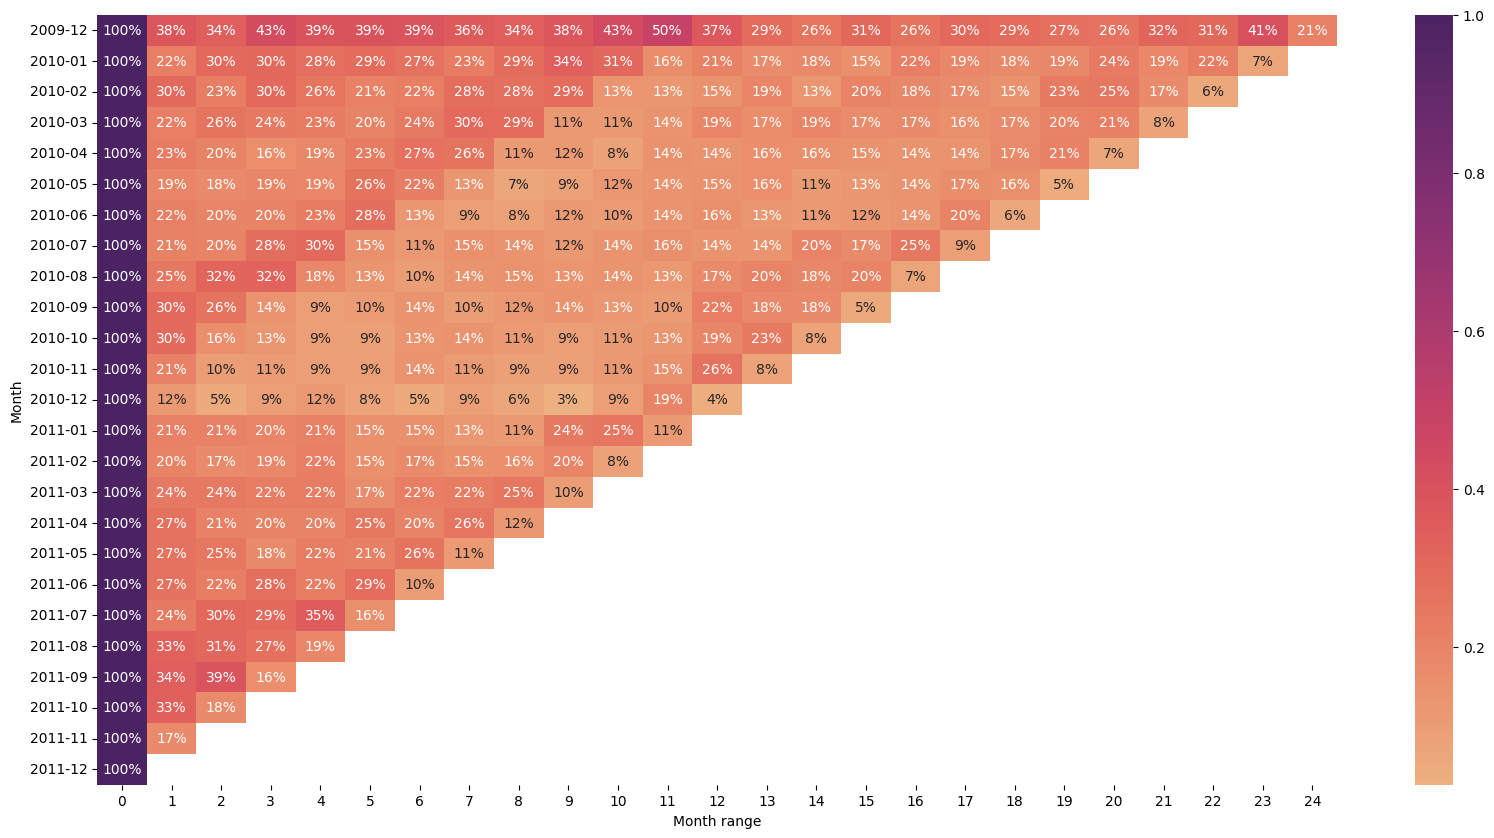

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(cohort, annot = True,cmap="flare", fmt=".0%")
plt.show()

In [30]:
cohort_country =  main.pivot_table(index='Country', columns='Month range', values='Customer ID', aggfunc='count')

In [31]:
cc_country = cohort_country.iloc[:,0]

In [32]:
cohort_country = cohort_country.divide(cc_country, axis = 0)

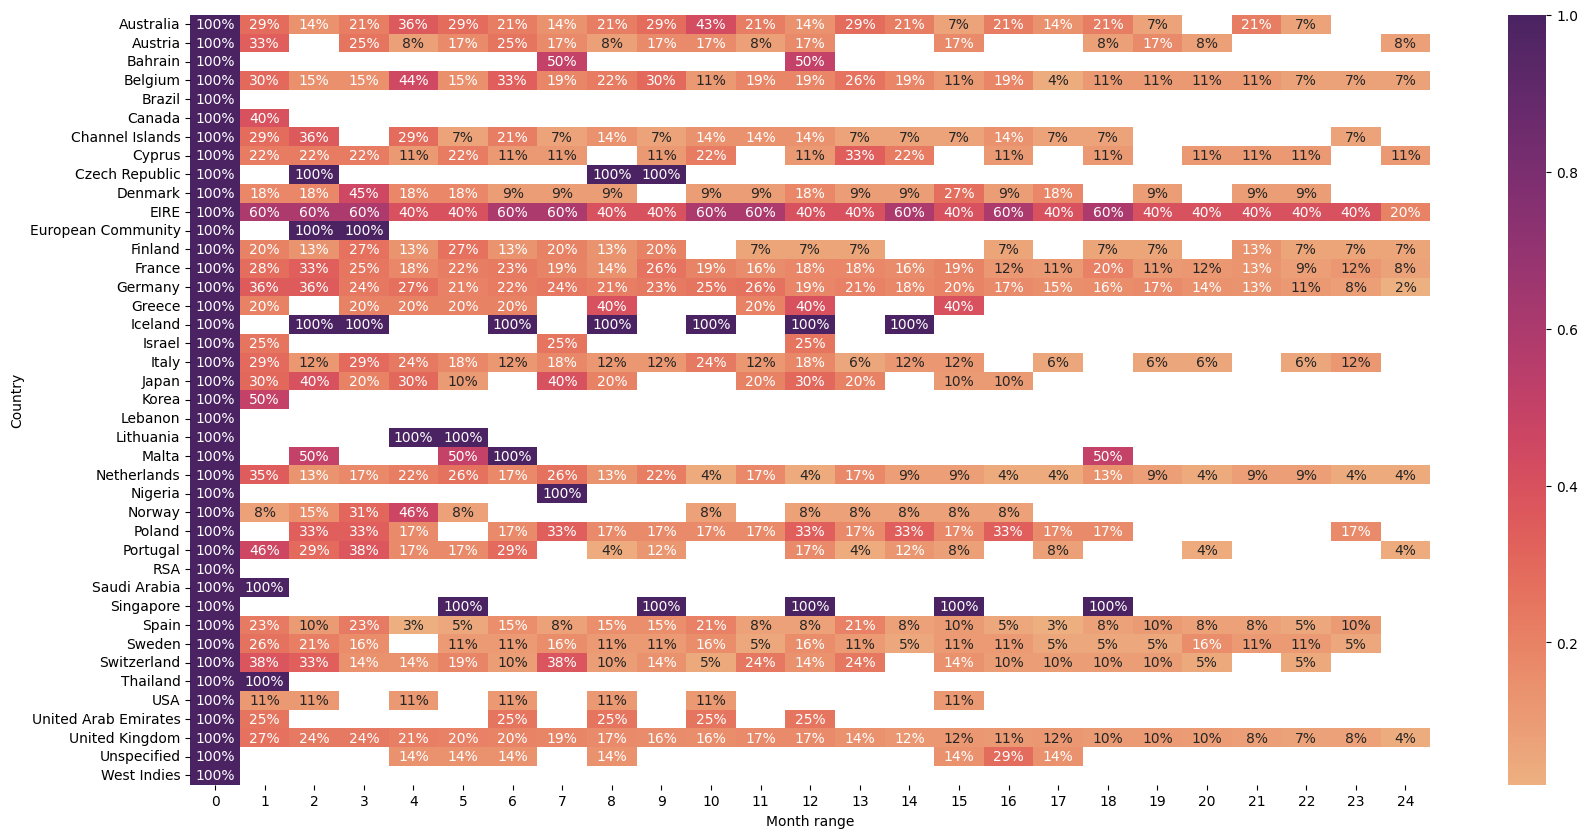

In [35]:
plt.figure(figsize=(20, 10))
sns.heatmap(cohort_country, annot = True,cmap="flare", fmt=".0%")
plt.show()